In [1]:
%matplotlib inline
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading

In [2]:
def read_ecg(file_path):
    """
    output: ecg files, get signal, annotated peaks, annotated types
    input: ecg file id
    """
    signals, fields = wfdb.rdsamp(file_path)
    annotation = wfdb.rdann(file_path, 'atr')
    ecg_sig = signals[:,0]
    ecg_type = annotation.symbol
    ecg_peak = annotation.sample
    return ecg_sig, ecg_type, ecg_peak

def plot_ecg(ecg_sig, ecg_type, ecg_peak, title='Fig: Train', npeak=10, len_sig=3000):
    """
    demo plot ecg signal with annotated peaks, annotated types
    """
    _, ax = plt.subplots()
    for i in range(0, npeak):
        ax.annotate(ecg_type[i], xy=(ecg_peak[i], -2))
    ax.plot(ecg_sig[0:len_sig])
    ax.plot(ecg_peak[0:npeak], ecg_sig[ecg_peak[0:npeak]], '*')
    ax.set_title(title)

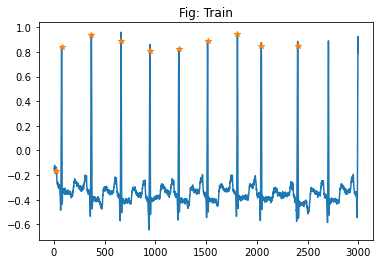

In [3]:
training_file_path = './database/train/100'
ecg_sig, ecg_type, ecg_peak = read_ecg(training_file_path)
plot_ecg(ecg_sig, ecg_type, ecg_peak)

# Features segmentation and extraction

In [4]:
mean_list = []
for idx, data in enumerate(ecg_peak):
    if (idx == 0):
        mean_list.append(np.mean(ecg_sig[0:ecg_peak[idx]]))
    else:
        mean_list.append(np.mean(ecg_sig[ecg_peak[idx-1]:ecg_peak[idx]]))
            
median_list = []
for idx, data in enumerate(ecg_peak):
    if (idx == 0):
        median_list.append(np.median(ecg_sig[0:ecg_peak[idx]]))
    else:
        median_list.append(np.median(ecg_sig[ecg_peak[idx-1]:ecg_peak[idx]]))
            
std_list = []
for idx, data in enumerate(ecg_peak):
    if (idx == 0):
        std_list.append(np.std(ecg_sig[0:ecg_peak[idx]]))
    else:
        std_list.append(np.std(ecg_sig[ecg_peak[idx-1]:ecg_peak[idx]]))

In [5]:
sample_matrix = np.array([mean_list, median_list, std_list, ecg_type])
sample_matrix = np.transpose(sample_matrix)

In [6]:
import pandas as pd
df = pd.DataFrame(sample_matrix, columns = ['Mean','Median','Standard Deviation', 'Target'])

df.head()

,Mean,Median,Standard Deviation,Target
0,-0.1513888888888889,-0.145,0.01543854803510028,+
1,-0.2250847457627119,-0.275,0.2149152208201867,N
2,-0.28732081911262797,-0.315,0.15950565529687027,N
3,-0.3325856164383562,-0.35,0.16973662978786663,N
4,-0.34466549295774646,-0.37,0.17272355611622014,N


In [7]:
df['Target'].replace(to_replace=['N','A','+','~','V','|','Q','R','"','F'], value =[0,1,1,1,1,1,1,1,1,1], inplace = True)
df.head(10)

,Mean,Median,Standard Deviation,Target
0,-0.1513888888888889,-0.145,0.01543854803510028,1
1,-0.2250847457627119,-0.275,0.2149152208201867,0
2,-0.28732081911262797,-0.315,0.15950565529687027,0
3,-0.3325856164383562,-0.35,0.16973662978786663,0
4,-0.34466549295774646,-0.37,0.17272355611622014,0
5,-0.322140350877193,-0.345,0.16399020494887837,0
6,-0.33010563380281693,-0.345,0.1631085229224715,0
7,-0.32301020408163267,-0.33,0.1618700344694534,0
8,-0.3128297872340426,-0.365,0.1883352961968939,1
9,-0.34135474860335197,-0.36,0.1474136234819065,0


# Splitting features into training and validation set

In [8]:
X = df[['Mean','Median','Standard Deviation']]
df['Target'] = pd.to_numeric(df['Target'])
y = df['Target']
y[0:5]

0    1
1    0
2    0
3    0
4    0
Name: Target, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)
print(X_train)
print(y_train)

                      Mean  Median   Standard Deviation
1455   -0.3225490196078431   -0.33  0.18832302387803845
546   -0.30081749049429657   -0.31  0.19824850211646247
979   -0.30776845637583894   -0.34  0.18795652274193994
619   -0.38350746268656716   -0.41  0.16999948403208165
1840  -0.26794701986754965  -0.275   0.1756490061231374
...                    ...     ...                  ...
1033   -0.2934561403508772  -0.315  0.18716509928969302
1731  -0.36157894736842106   -0.39  0.18178394225577205
763    -0.3267204301075269  -0.325  0.17863203999183058
835    -0.2848479087452472   -0.31  0.19914497763036487
1653                -0.246   -0.26  0.18722947736129178

[1705 rows x 3 columns]
1455    0
546     0
979     0
619     0
1840    0
       ..
1033    0
1731    0
763     0
835     0
1653    0
Name: Target, Length: 1705, dtype: int64


# Features scaling

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

# Features classification using SVM

In [10]:
from sklearn.svm import SVC
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [11]:
from sklearn.model_selection import GridSearchCV
svm_cv = GridSearchCV(svm, parameters)
svm_cv.fit(X_train[0:500],y_train[0:500])

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [12]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'gamma': 1.0, 'kernel': 'sigmoid'}
accuracy : 0.9960000000000001


In [13]:
yhat_svm_2 = svm_cv.predict(X_val)
yhat_svm_2[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [14]:
import sklearn.metrics as metrics
print("Validation set Accuracy: ", metrics.accuracy_score(y_val, yhat_svm_2))

Validation set Accuracy:  0.9912126537785588


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf','poly', 'sigmoid']}
 
grid = HalvingGridSearchCV(svm, param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train,y_train)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 21
max_resources_: 1705
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 21
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, gamma=1, kernel=linear;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s

[CV 3/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=0.1, gamma=0.0001, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=1, kernel=linear;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1, gamma=1, kernel=linear;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=1, gamma=1, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=1, kernel=rbf;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=1, kernel=rbf;, score=(train=nan, test=nan

[CV 1/5] END C=10, gamma=1, kernel=rbf;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=10, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, gamma=1, kernel=rbf;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=10, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, gamma=1, kernel=poly;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=10, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=10, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=10, gamma=1, kernel=poly;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=10, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.938, test=1.000) total time=   0.0s
[CV

[CV 2/5] END C=100, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, gamma=1, kernel=poly;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=100, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, gamma=1, kernel=sigmoid;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=100, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=100, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=100, gamma=1, kernel=sigmoid;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=100, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=100, gamma=0.1, kernel=linear;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=100, gamma=0.1, kernel=linear;, score=(train=nan, 

[CV 2/5] END C=1000, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, gamma=1, kernel=poly;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=1000, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, gamma=1, kernel=sigmoid;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=1000, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1000, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END C=1000, gamma=1, kernel=sigmoid;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 5/5] END C=1000, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1000, gamma=0.1, kernel=linear;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=1000, gamma=0.1, kernel=linear;, score=(

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than on

[CV 4/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=1, kernel=poly;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=1, kernel=poly;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 4/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, gamma=1, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=1, kernel=sigmoid;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=1, kernel=sigmoid;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 4/5] END C=1, gamma=1, kernel=sigmoid;, score=(train=nan, test=nan) total time=   0.0s
[C

[CV 3/5] END C=1, gamma=0.001, kernel=poly;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001, kernel=poly;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001, kernel=rbf;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001, kernel=rbf;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001, kernel=rbf;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001, kernel=linear;, score=(train=0.960, test=1.000) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001, kernel=linear;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001, kernel=linear;, score=(train=0.960

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
102 fits failed out of a total of 170.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
102 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\Acer\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than on

[CV 3/5] END C=1, gamma=0.1, kernel=rbf;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 4/5] END C=1, gamma=0.1, kernel=rbf;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 5/5] END C=1, gamma=0.1, kernel=rbf;, score=(train=0.974, test=1.000) total time=   0.0s
[CV 1/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 2/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 3/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 4/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 5/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.974, test=1.000) total time=   0.0s
[CV 1/5] END C=10, gamma=0.1, kernel=poly;, score=(train=0.987, test=1.000) total time=   0.0s
[CV 2/5] END C=10, gamma=0.1, kernel=poly;, score=(train=0.993, test=1.000) total time=   0.0s
[CV 3/5] END C=10, gamma=0.1, kernel=poly

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.]
  warnings.warn(
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan    


[CV 5/5] END C=10, gamma=0.1, kernel=linear;, score=(train=0.987, test=0.965) total time=   0.0s
[CV 1/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.985, test=0.991) total time=   0.0s
[CV 2/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.980, test=0.982) total time=   0.0s
[CV 3/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.989, test=0.965) total time=   0.0s
[CV 4/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 5/5] END C=10, gamma=1, kernel=sigmoid;, score=(train=0.987, test=0.965) total time=   0.0s
[CV 1/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.985, test=0.991) total time=   0.0s
[CV 2/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.980, test=0.982) total time=   0.0s
[CV 3/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.989, test=0.965) total time=   0.0s
[CV 4/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 5/5] END C=1, gamma=0.1, kernel=li

C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        na

[CV 2/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 3/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.984, test=0.982) total time=   0.0s
[CV 4/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 5/5] END C=1, gamma=0.1, kernel=linear;, score=(train=0.984, test=0.982) total time=   0.0s
[CV 1/5] END C=1000, gamma=0.0001, kernel=sigmoid;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 2/5] END C=1000, gamma=0.0001, kernel=sigmoid;, score=(train=0.983, test=0.985) total time=   0.0s
[CV 3/5] END C=1000, gamma=0.0001, kernel=sigmoid;, score=(train=0.984, test=0.982) total time=   0.0s
[CV 4/5] END C=1000, gamma=0.0001, kernel=sigmoid;, score=(train=0.985, test=0.982) total time=   0.0s
[CV 5/5] END C=1000, gamma=0.0001, kernel=sigmoid;, score=(train=0.984, test=0.982) total time=   0.0s


C:\Users\Acer\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        na

HalvingGridSearchCV(estimator=SVC(),
                    param_grid={'C': [0.1, 1, 10, 100, 1000],
                                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
                    verbose=3)

In [19]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
SVC(C=1, gamma=0.1, kernel='linear')


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
grid_predictions = grid.predict(X_val)
 
# print classification report
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       562
           1       0.00      0.00      0.00         7

    accuracy                           0.99       569
   macro avg       0.49      0.50      0.50       569
weighted avg       0.98      0.99      0.98       569



C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Acer\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


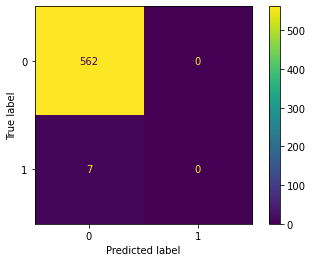

In [23]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_svm = confusion_matrix(y_val, grid_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=grid.classes_)
disp.plot()
plt.show()

# Features classification using K-NN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
knn_c = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_c.fit(X_train, y_train)

KNeighborsClassifier()

In [25]:
yhat_knn = knn_c.predict(X_val)

In [26]:
cm_knn= confusion_matrix(y_val, yhat_knn)

# Features classification using Randon Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf_c = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf_c.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [28]:
yhat_rf = rf_c.predict(X_val)

In [29]:
cm_rf= confusion_matrix(y_val, yhat_rf)

# Features classification using ANN

In [30]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(activation="relu", input_dim=3, units=5, kernel_initializer="uniform"))

# Adding the second hidden layer
classifier.add(Dense(activation="relu",units=5, kernel_initializer="uniform"))

# Adding the output layer
classifier.add(Dense(activation="sigmoid", kernel_initializer="uniform", units=1))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100


UnimplementedError:  Cast string to float is not supported
	 [[node sequential/Cast
 (defined at C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:637)
]] [Op:__inference_train_function_727]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/Cast:
In[0] IteratorGetNext (defined at C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:848)

Operation defined at: (most recent call last)
>>>   File "C:\Users\Acer\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Acer\AppData\Local\Temp/ipykernel_18160/3677519975.py", line 22, in <module>
>>>     classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1189, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 859, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 849, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 842, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 799, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1044, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py", line 379, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 419, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 537, in _run_internal_graph
>>>     y = self._conform_to_reference_input(y, ref_input=x)
>>> 
>>>   File "C:\Users\Acer\anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py", line 637, in _conform_to_reference_input
>>>     tensor = math_ops.cast(tensor, dtype=ref_input.dtype)
>>> 

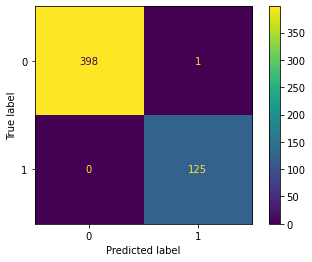

In [41]:
# Making the predictions and evaluating the model

# Predicting the Test set results
yhat_ann = classifier.predict(X_val)
yhat_ann = (yhat_ann > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_ann = confusion_matrix(y_val, yhat_ann)

labels = ["0", "1"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=labels)

disp.plot()
plt.show()

# Performance Measure on different machine learning models

In [22]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    #print('True Positives:', TP)
    #print('True Negatives:', TN)
    #print('False Positives:', FP)
    #print('False Negatives:', FN)
    #print(" ")
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    #print('-'*50)
    #print(f'Accuracy: {round(conf_accuracy,2)}') 
    #print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    #print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    #print(f'Specificity: {round(conf_specificity,2)}') 
    #print(f'Precision: {round(conf_precision,2)}')
    #print(f'f_1 Score: {round(conf_f1,2)}')
    return TP, TN, FP, FN, conf_accuracy, conf_misclassification, conf_sensitivity, conf_specificity, conf_precision, conf_f1

In [24]:
svm_cm = confusion_metrics(cm_svm)
round(svm_cm[4],4)*100

99.62

In [33]:
svm_cm = confusion_metrics(cm_svm)
acc_svm = round(svm_cm[4],4)*100
sen_svm = round(svm_cm[6],4)*100
spec_svm = round(svm_cm[7],4)*100
pre_svm = round(svm_cm[8],4)*100
f1_svm = round(svm_cm[9],4)*100

knn_cm = confusion_metrics(cm_knn)
acc_knn = round(knn_cm [4],4)*100
sen_knn = round(knn_cm [6],4)*100
spec_knn = round(knn_cm [7],4)*100
pre_knn = round(knn_cm [8],4)*100
f1_knn = round(knn_cm[9],4)*100

rf_cm = confusion_metrics(cm_rf)
acc_rf = round(rf_cm [4],4)*100
sen_rf = round(rf_cm[6],4)*100
spec_rf = round(rf_cm [7],4)*100
pre_rf = round(rf_cm [8],4)*100
f1_rf = round(rf_cm[9],4)*100

ann_cm = confusion_metrics(cm_ann)
acc_ann = round(ann_cm[4],4)*100
sen_ann = round(ann_cm[6],4)*100
spec_ann = round(ann_cm[7],4)*100
pre_ann = round(ann_cm[8],4)*100
f1_ann = round(ann_cm[9],4)*100

Accuracy = [acc_svm, acc_knn, acc_rf, acc_ann]
Sensitivity = [sen_svm, sen_knn, sen_rf, sen_ann]
Specificity = [spec_svm, spec_knn, spec_rf, spec_ann]
Precision = [pre_svm, pre_knn, pre_rf, pre_ann]
F1 = [f1_svm, f1_knn, f1_rf, f1_ann]

df_score = {'Algorithm': ['SVM', 'K-NN', 'Randon Forest', 'ANN'], 'Accuracy': Accuracy, 'Sensitivity':Sensitivity, 'Specificity':Specificity, 'Precision':Precision, 'F1-score':F1}
Perform_measure = pd.DataFrame(data = df_score, columns = ['Algorithm', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-score'], index = None)
Perform_measure

,Algorithm,Accuracy,Sensitivity,Specificity,Precision,F1-score
0,SVM,99.62,99.2,99.75,99.20,99.20
1,K-NN,99.62,98.4,100.00,100.00,99.19
2,Randon Forest,99.43,99.2,99.50,98.41,98.80
3,ANN,99.81,100.0,99.75,99.21,99.60


In [ ]:
#performance metrics
print("SVM")
print("")
confusion_metrics(cm_svm)
print('-'*50)
print("")
print("K-NN")
print("")
confusion_metrics(cm_knn)
print('-'*50)
print("")
print("Randon Forest")
print("")
confusion_metrics(cm_rf)
print('-'*50)
print("")
print("ANN")
print("")
confusion_metrics(cm_ann)

In [ ]:
from sklearn import metrics
AUC_svm = metrics.auc(X_val, y_val)
print(AUC_svm)

In [ ]:
from sklearn import metrics
metrics.plot_roc_curve(knn_c, X_val, y_val)
plt.show()